# 04 Multiple Linear regression model trained on entire dataset 

> This is the regression model trained on the entire dataset and all covariates 

In [1]:
#|default_exp core.04_regression_model

In [2]:
#|hide
import nbdev; nbdev.nbdev_export()

/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/nbdev/export.py:73: UserWarning: Notebook '/Users/bea/adu_dev/dementia_inequalities/nbs/core/03a_explore_datasets.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"


In [3]:
#|hide
from nbdev.showdoc import show_doc

In [4]:
#|export
import dementia_inequalities as proj
from dementia_inequalities import const
import adu_proj.utils as adutils

In [5]:
#|export
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import matplotlib.font_manager as fm
from sklearn import linear_model
from sklearn.model_selection import KFold, cross_val_score
import itertools

import scipy.stats as st

### Load the Autonomy style bits 

In [6]:
# Define the font path and style path
FONT_PATH = const.raw_data_path + '/JosefinSans-Regular.ttf'
STYLEPATH = const.raw_data_path + '/autonomy_white.mplstyle'

# Add the font to the font manager
fm.fontManager.addfont(FONT_PATH)

# Set the font family for matplotlib to use
plt.rcParams['font.family'] = 'Josefin Sans'
plt.style.use(STYLEPATH)

# Inform the user that the font was set
print("Josefin Sans font set for Matplotlib.")
print("mplstyle activated.")

Josefin Sans font set for Matplotlib.
mplstyle activated.


---

This model looks at automating the choice of parameters and the choice of training dataset using k-fold cross validation. 

In [7]:
#|export 
df_dem_plus = pd.read_csv(const.output_path+'/df_dem_plus.csv')

In [8]:
df_dem_plus.head()

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,...,white_pc,DEM_afflicted_pc,ALevel_plus_pc,over_65_pc,female_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_contribution_to_LAD,GP_LAD_pc
0,E07000091,New Forest,151481,1858.546949,28892.139020,9338.695410,4466.648271,72749.0,91513.3596,84729.6073,...,93.2,1.054537,41.277676,29.459719,51.924546,16.393357,5.298762,2.534370,186.084815,0.105584
1,E09000027,Richmond upon Thames,156795,1016.262785,16263.714161,5723.913130,2019.443594,112919.0,101226.6730,93918.3682,...,63.0,0.520773,57.864140,16.212434,51.872532,8.334167,2.933158,1.034842,437.450820,0.224167
2,E07000116,Tunbridge Wells,95022,876.255260,12908.434533,4606.674451,1889.024705,52395.0,59540.1412,56126.1458,...,84.2,0.757572,45.298420,19.513040,51.475795,11.160066,3.982729,1.633168,124.734713,0.107840
3,E07000121,Lancaster,123214,1228.376774,16806.421220,6784.714317,2647.583108,65724.0,72615.6480,69496.5141,...,87.8,0.864371,46.247977,20.734161,51.097420,11.826167,4.774197,1.863024,442.084950,0.311082
4,E07000042,Mid Devon,67987,547.793487,10854.465333,4281.878984,1530.207441,33190.0,42541.3752,40639.6312,...,93.8,0.658556,39.900936,24.100070,51.143136,13.049211,5.147664,1.839612,78.032656,0.093811


These are the covariates I'm interested in - each is calculated as a percentage of the total population of the region. 
* Age (% people over 65) `over_65_pc`
* Gender (% people female) `female_pc`
* Educational attainment (% people with A-level or higher education) `ALevel_plus_pc`
* Ethnicity (% people who are white British) `white_pc`
* Comorbidities (% people with various dementia comorbidities)
    - Hypertension `HYP_afflicted_pc`
    - Diabetes `DM_afflicted_pc`
    - Stroke `STIA_afflicted_pc`
* Density of GPs (total number of GPs/ pop) `GP_LAD_pc`

In [9]:
#|export
# Potential covariates 
covar_opt = ['over_65_pc', 
             'female_pc', 
             'ALevel_plus_pc', 
             'white_pc', 
             'HYP_afflicted_pc', 
             'DM_afflicted_pc', 
             'STIA_afflicted_pc',
             'GP_LAD_pc']

covar_opt_noGP = ['over_65_pc', 
             'female_pc', 
             'ALevel_plus_pc', 
             'white_pc', 
             'HYP_afflicted_pc', 
             'DM_afflicted_pc', 
             'STIA_afflicted_pc']

covar_opt_no_comor  = ['over_65_pc', 
             'female_pc', 
             'ALevel_plus_pc', 
             'white_pc', 
#             'HYP_afflicted_pc', 
#             'DM_afflicted_pc', 
#             'STIA_afflicted_pc',
             'GP_LAD_pc']


This performs 5 fold cross-validation to determine the best combination of covariates. 

In [10]:
# Outcome data 
Y_data = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

# Parameters for cross validation 
n_folds = 5
cv_kfold = KFold(n_folds, random_state=13, shuffle=True)

# Model 
model = linear_model.LinearRegression()

covar_comb = {}
perform_by_covar = {}

key_num = 0
for i in range(1,9):
    for j, subset in enumerate(itertools.combinations(covar_opt, i)):
        covar_comb[key_num] = subset
        X_data = df_dem_plus[list(subset)].values.reshape(-1,i)
        # evaluate the model using 5-fold CV 
        scores = cross_val_score(model, X=X_data, y=Y_data, cv=cv_kfold)
        perform_by_covar[key_num] = np.mean(scores)
        key_num += 1
        #print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

In [11]:
# Best combination of covariates
covar_comb[max(perform_by_covar, key=perform_by_covar.get)]

('over_65_pc',
 'female_pc',
 'HYP_afflicted_pc',
 'DM_afflicted_pc',
 'STIA_afflicted_pc',
 'GP_LAD_pc')

In [12]:
# Top 5 combination of covariates 
max_5 = sorted(perform_by_covar, key=perform_by_covar.get, reverse=True)[:5]
[f'Covariates:{covar_comb[x]}, Accuracy:{perform_by_covar[x]}' for x in max_5]

["Covariates:('over_65_pc', 'female_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc', 'GP_LAD_pc'), Accuracy:0.8018379734899914",
 "Covariates:('over_65_pc', 'female_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc'), Accuracy:0.8015130187062459",
 "Covariates:('over_65_pc', 'female_pc', 'white_pc', 'HYP_afflicted_pc', 'STIA_afflicted_pc', 'GP_LAD_pc'), Accuracy:0.8013688764017246",
 "Covariates:('over_65_pc', 'female_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc', 'GP_LAD_pc'), Accuracy:0.8012476864556076",
 "Covariates:('over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'STIA_afflicted_pc', 'GP_LAD_pc'), Accuracy:0.8010291085752337"]

In [13]:
# Create dataframe of combinations of covariates
df_covar_comb = pd.DataFrame.from_dict(covar_comb, orient='index')
df_covar_comb.columns = ['covariate 1', 'covariate 2', 'covariate 3', 'covariate 4', 'covariate 5', 'covariate 6', 'covariate 7', 'covariate 8'
                         ]

# Create dataframe of accuracy
df_accuracy = pd.DataFrame.from_dict(perform_by_covar, orient='index')
df_accuracy.rename(columns={0:'accuracy (mean)'}, inplace=True)

# Merge 
df_model_acc = pd.merge(df_accuracy, df_covar_comb, left_index=True, right_index=True)

In [14]:
# This dataframe records the model accuracy for every combination of covariates 
df_model_acc

,accuracy (mean),covariate 1,covariate 2,covariate 3,covariate 4,covariate 5,covariate 6,covariate 7,covariate 8
0,0.769187,over_65_pc,None,None,None,None,None,None,None
1,-0.018927,female_pc,None,None,None,None,None,None,None
2,0.025560,ALevel_plus_pc,None,None,None,None,None,None,None
3,0.546197,white_pc,None,None,None,None,None,None,None
4,0.694735,HYP_afflicted_pc,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...
250,0.800702,over_65_pc,female_pc,ALevel_plus_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_LAD_pc,None
251,0.801248,over_65_pc,female_pc,white_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_LAD_pc,None
252,0.794285,over_65_pc,ALevel_plus_pc,white_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_LAD_pc,None
253,0.782539,female_pc,ALevel_plus_pc,white_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_LAD_pc,None


## All possible covariates 
What happens if I include all possible covariates?

In [15]:
print(covar_opt)

['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc', 'GP_LAD_pc']


In [16]:
#|export
# Linear regression using sklearn 

x = df_dem_plus[covar_opt].values.reshape(-1,len(covar_opt))
y = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

regr = linear_model.LinearRegression()

# fit regression comorbidities
regr.fit(x, y)
y_pred = regr.predict(x)

In [17]:
print(regr.intercept_[0])

-1.0385475522921253


In [18]:
#|export
# save the regression coefficients so that I can use them in a different nb 

reg_coefficients = np.concatenate([regr.intercept_, regr.coef_[0]])
np.save(const.pre_output_path+'/reg_coeff.npy', reg_coefficients)

In [19]:
print("Regression estimates \n--------------\n--------------")
print(f'Intercept:{regr.intercept_[0]}')
print("--------------\nCoefficients of independent variables \n--------------")
for i, var in enumerate(covar_opt):
    print(f'{var}:{regr.coef_[0][i]} \n')

Regression estimates 
--------------
--------------
Intercept:-1.0385475522921253
--------------
Coefficients of independent variables 
--------------
over_65_pc:0.013643438240639653 

female_pc:0.019931377968404565 

ALevel_plus_pc:0.00025756455703306215 

white_pc:0.00013860336993529597 

HYP_afflicted_pc:0.01909478574511777 

DM_afflicted_pc:-0.014883041822633865 

STIA_afflicted_pc:0.1223357947494969 

GP_LAD_pc:0.08140487448379698 



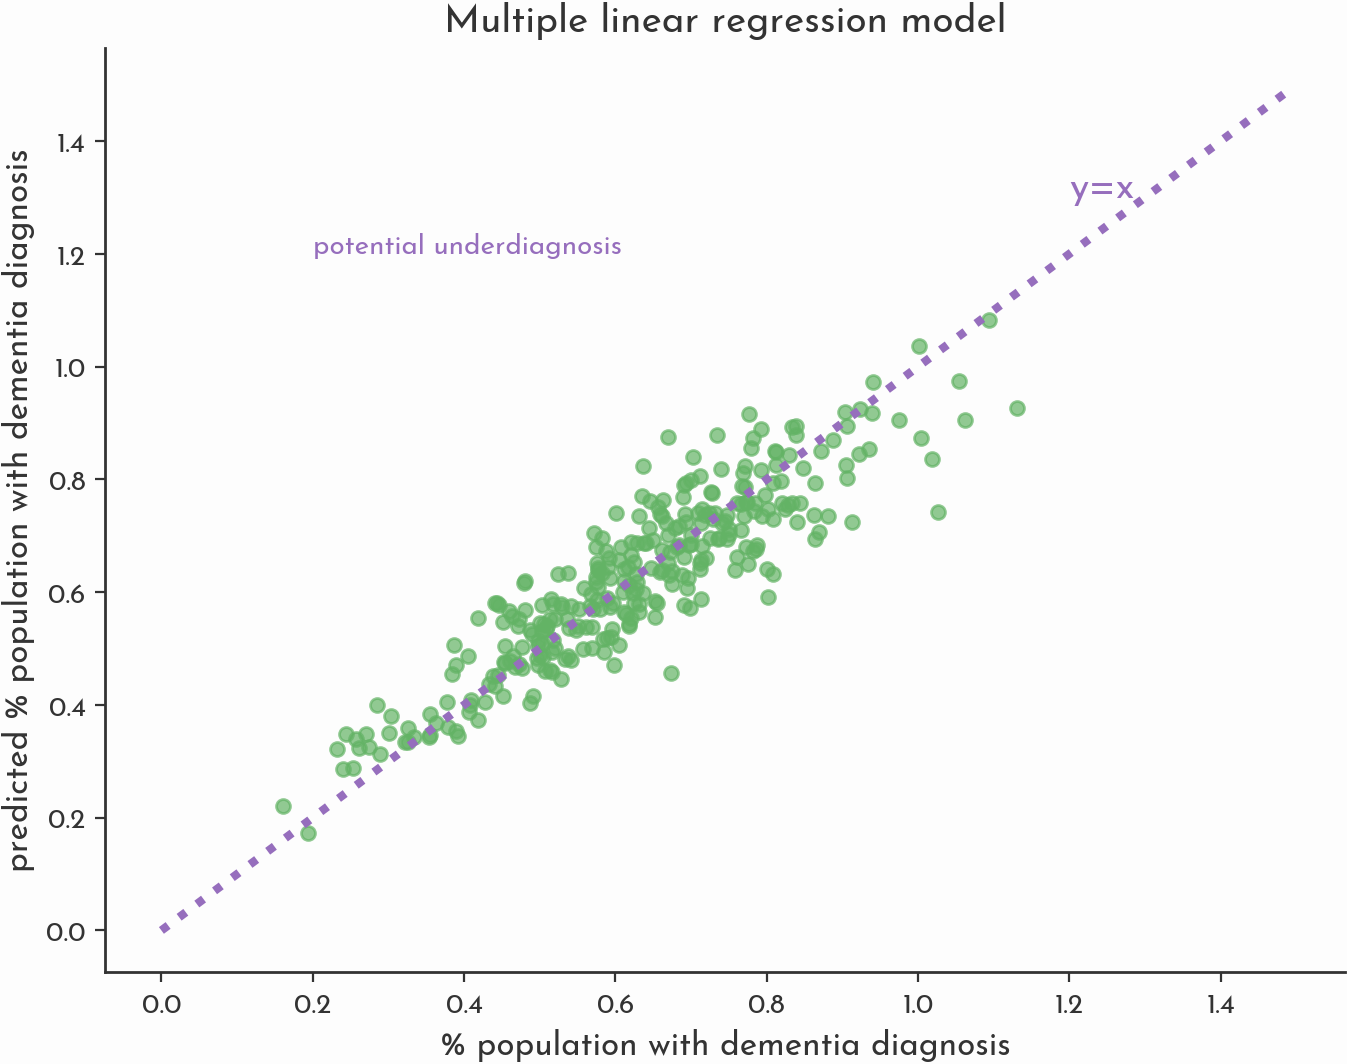

In [20]:
# comparison between true diagnosis value, and the value predicted by the multiple linear regression model 

plt.figure(figsize=(8,6), dpi=200)
plt.plot(np.arange(0, 1.5, 0.01), np.arange(0, 1.5, 0.01), ':', color='xkcd:deep lilac')
plt.scatter(y, y_pred, color='xkcd:boring green', alpha=0.7)
plt.xlabel('% population with dementia diagnosis', fontsize=12)
plt.ylabel('predicted % population with dementia diagnosis', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Multiple linear regression model', fontsize=14)
plt.text(1.2, 1.3, r'y=x', fontsize=14, color='xkcd:deep lilac')
plt.text(0.2, 1.2, r'potential underdiagnosis', fontsize=10, color='xkcd:deep lilac')
plt.savefig(const.figs_path+'/linear_reg_scatter_plt.png')
plt.show()


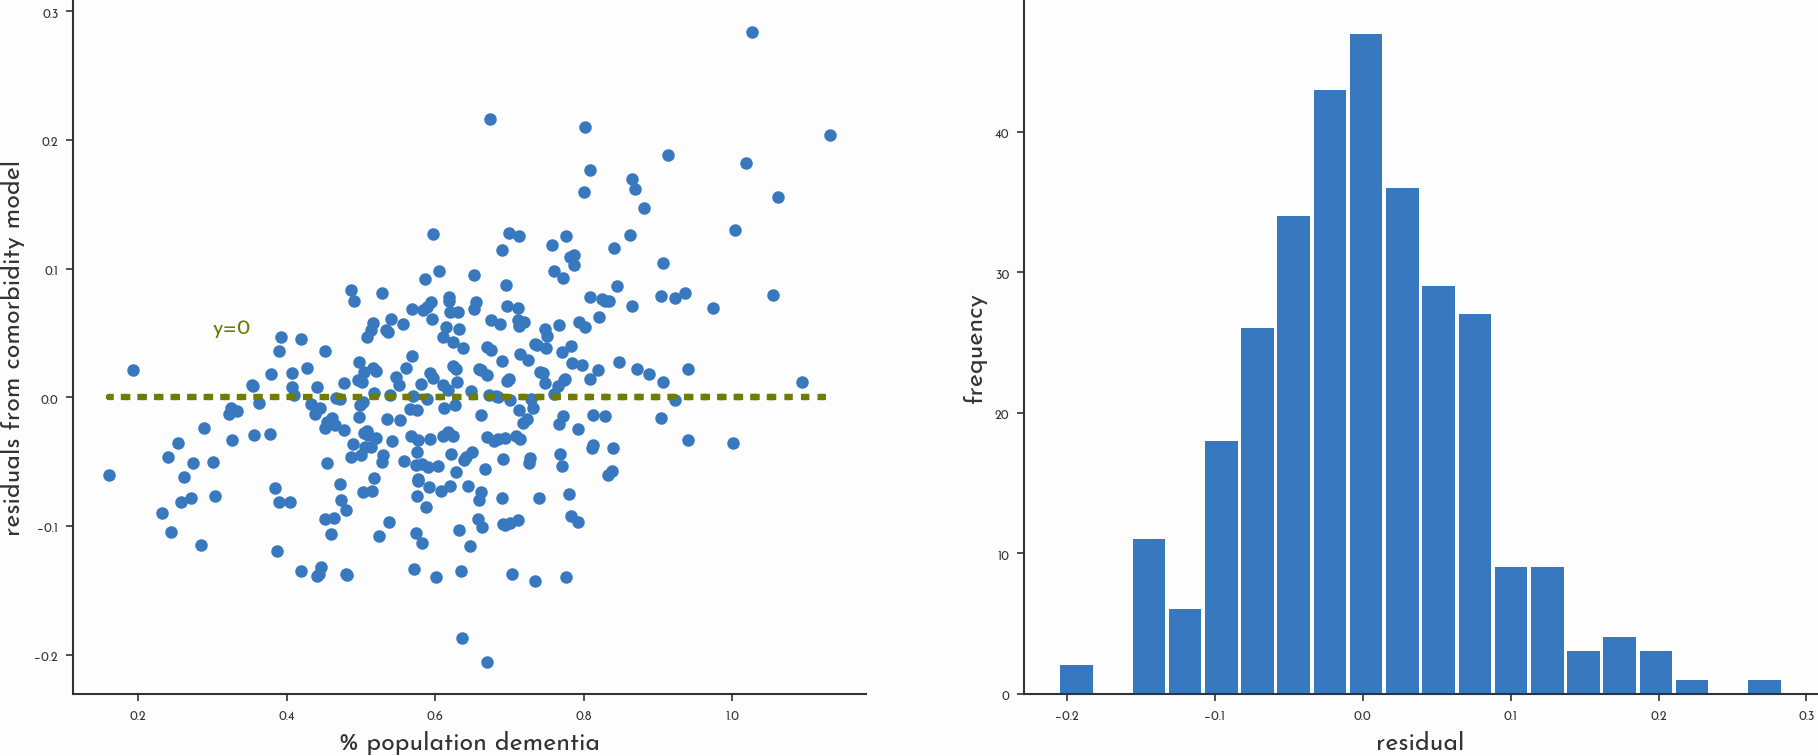

In [21]:
plt.subplots(nrows=1, ncols= 2, figsize = (15,6))

residuals = (y - y_pred).reshape(309)
 
# look at the residuals 
plt.subplot(1, 2, 1)
plt.scatter(y, residuals, color='xkcd:windows blue')
plt.plot(y, np.zeros(len(y)), ':', color='xkcd:poop green')
plt.text(0.3, 0.05, r'y=0', fontsize=10, color='xkcd:poop green')
plt.ylabel('residuals from comorbidity model', fontsize=12)
plt.xlabel('% population dementia', fontsize=12)

# histogram plot of the models residuals
plt.subplot(1, 2, 2)
plt.hist(residuals, color='xkcd:windows blue', rwidth=0.9, bins=20)
plt.xlabel('residual', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.show()

And repeat without the GP covariate 

In [22]:
# Linear regression using sklearn 

x_noGP = df_dem_plus[covar_opt_noGP].values.reshape(-1,len(covar_opt_noGP))
y = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

regr_noGP = linear_model.LinearRegression()

# fit regression comorbidities
regr_noGP.fit(x_noGP, y)
y_pred_noGP = regr_noGP.predict(x_noGP)

print("Regression estimates \n--------------\n--------------")
print(f'Intercept:{regr_noGP.intercept_[0]}')
print("--------------\nCoefficients of independent variables \n--------------")
for i, var in enumerate(covar_opt_noGP):
    print(f'{var}:{regr_noGP.coef_[0][i]} \n')

Regression estimates 
--------------
--------------
Intercept:-1.0519360202462669
--------------
Coefficients of independent variables 
--------------
over_65_pc:0.013364294343963622 

female_pc:0.02017164460185772 

ALevel_plus_pc:0.0004801156618657718 

white_pc:0.00012520548339076362 

HYP_afflicted_pc:0.01983868714180155 

DM_afflicted_pc:-0.015093069340706462 

STIA_afflicted_pc:0.12289602950530826 



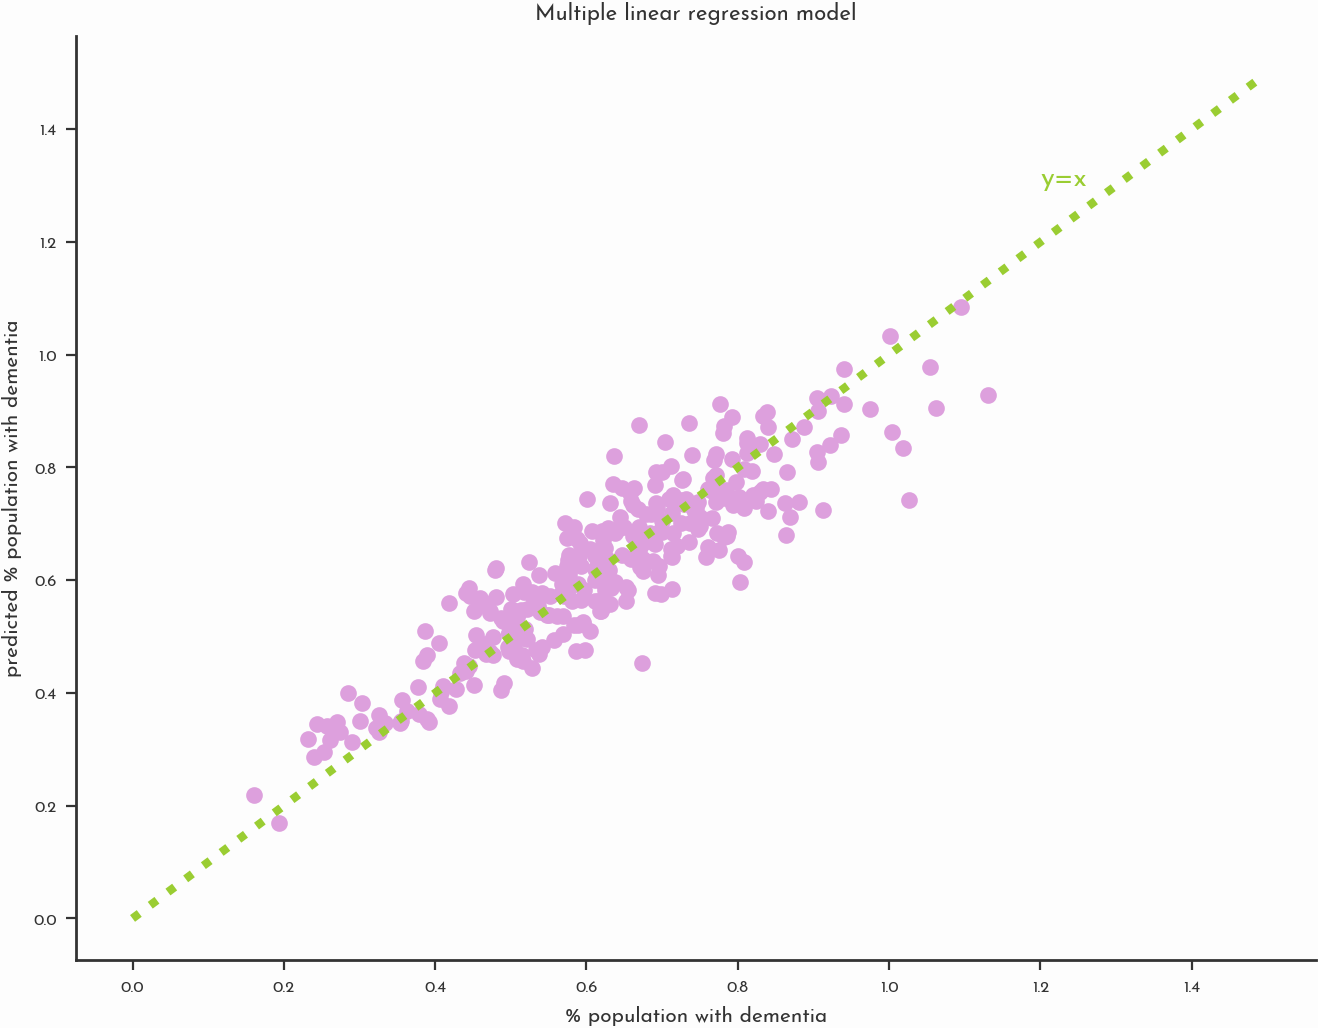

In [23]:
# comparison between true diagnosis value, and the value predicted by the multiple linear regression model 

plt.figure(figsize=(8,6), dpi=200)
plt.plot(np.arange(0, 1.5, 0.01), np.arange(0, 1.5, 0.01), ':', color='yellowgreen')
plt.scatter(y, y_pred_noGP, color='plum')
plt.xlabel('% population with dementia')
plt.ylabel('predicted % population with dementia')
plt.title('Multiple linear regression model')
plt.text(1.2, 1.3, r'y=x', fontsize=10, color='yellowgreen')
#plt.text(0.2, 0.12, r'potential underdiagnosis', fontsize=10)
plt.show()

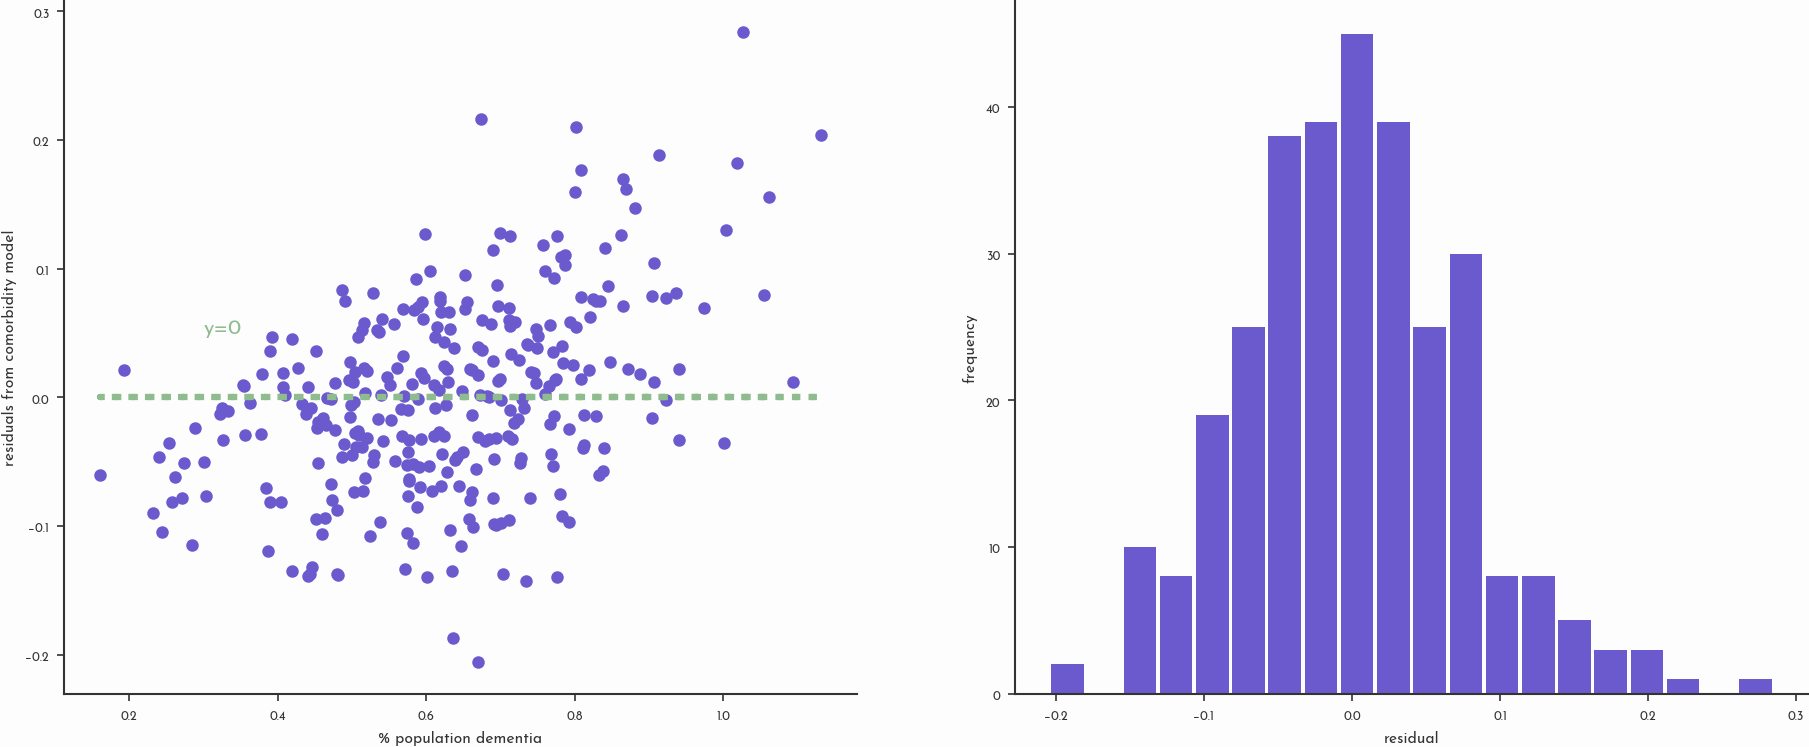

In [24]:
plt.subplots(nrows=1, ncols= 2, figsize = (15,6))

residuals_noGP = (y - y_pred_noGP).reshape(309)
 
# look at the residuals 
plt.subplot(1, 2, 1)
plt.scatter(y, residuals, color='slateblue')
plt.plot(y, np.zeros(len(y)), ':', color='darkseagreen')
plt.text(0.3, 0.05, r'y=0', fontsize=10, color='darkseagreen')
plt.ylabel('residuals from comorbidity model')
plt.xlabel('% population dementia')

# histogram plot of the models residuals
plt.subplot(1, 2, 2)
plt.hist(residuals_noGP, color='slateblue', rwidth=0.9, bins=20)
plt.xlabel('residual')
plt.ylabel('frequency')
plt.show()

## Repeat including GP numbers, but excluding the comorbidities

In [25]:
import statsmodels.api as sm 
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [26]:
# variables 
x_all_covar = df_dem_plus[covar_opt_no_comor]

# VIF datafram 
vif_data = pd.DataFrame()
vif_data["feature"] = x_all_covar.columns

# calculate VIF for each factor 
x_all_covar_const = add_constant(x_all_covar)
#vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]


pd.Series([variance_inflation_factor(x_all_covar_const.values, i)
                          for i in range(x_all_covar_const.shape[1])],
                          index=x_all_covar_const.columns)

const             5879.665461
over_65_pc           3.339684
female_pc            1.063786
ALevel_plus_pc       1.209714
white_pc             3.422260
GP_LAD_pc            1.079291
dtype: float64

In [27]:
# Linear regression using sklearn 

x_nocomor = df_dem_plus[covar_opt_no_comor].values.reshape(-1,len(covar_opt_no_comor))
y = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

regr_nocomor = linear_model.LinearRegression()

# fit regression comorbidities
regr_nocomor.fit(x_nocomor, y)
y_pred_nocomor = regr_nocomor.predict(x_nocomor)

# save residuals 
residuals_nocomor = (y - y_pred_nocomor).reshape(309)

print("Regression estimates \n--------------\n--------------")
print(f'Intercept:{regr_nocomor.intercept_[0]}')
print("--------------\nCoefficients of independent variables \n--------------")
for i, var in enumerate(covar_opt_no_comor):
    print(f'{var}:{regr_nocomor.coef_[0][i]} \n')

Regression estimates 
--------------
--------------
Intercept:-1.1020440574909207
--------------
Coefficients of independent variables 
--------------
over_65_pc:0.027200030320553504 

female_pc:0.02215972284843058 

ALevel_plus_pc:-0.0007202039605086789 

white_pc:0.0009109777506433679 

GP_LAD_pc:0.13830401298301845 



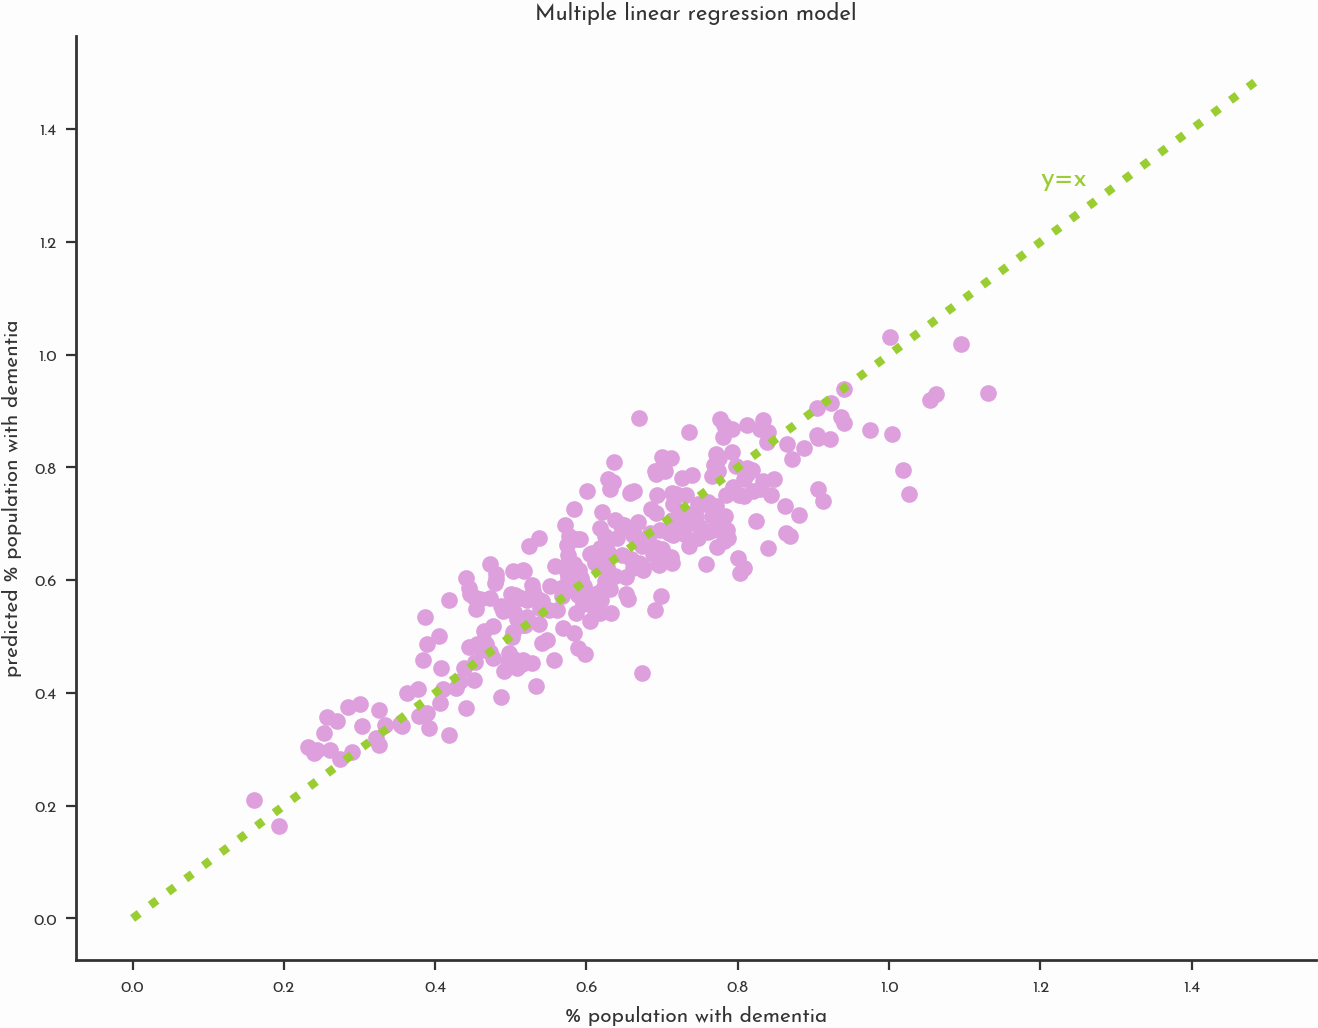

In [28]:
# comparison between true diagnosis value, and the value predicted by the multiple linear regression model 

plt.figure(figsize=(8,6), dpi=200)
plt.plot(np.arange(0, 1.5, 0.01), np.arange(0, 1.5, 0.01), ':', color='yellowgreen')
plt.scatter(y, y_pred_nocomor, color='plum')
plt.xlabel('% population with dementia')
plt.ylabel('predicted % population with dementia')
plt.title('Multiple linear regression model')
plt.text(1.2, 1.3, r'y=x', fontsize=10, color='yellowgreen')
#plt.text(0.2, 0.12, r'potential underdiagnosis', fontsize=10)
plt.show()

### Save the results of the regression model to a .csv 

In [29]:
# add columns of results to the dataframe 
df_dem_plus['reg_model_residuals'] = residuals
df_dem_plus['reg_model_pred'] = y_pred

df_dem_plus['reg_model_noGP_residuals'] = residuals_noGP
df_dem_plus['reg_model_noGP_pred'] = y_pred_noGP

df_dem_plus['reg_model_nocomor_residuals'] = residuals_nocomor
df_dem_plus['reg_model_nocomor_pred'] = y_pred_nocomor

# save the dataframe 
df_dem_plus.to_csv(const.output_path+'/reg_model/reg_model_results.csv')

### And analyse the residuals 

In [30]:
# residuals 

# look at areas with gap between predicted diagnosis rate and observed diagnosis rate 
resid_gap_area = df_dem_plus[residuals<-0.15]['area_name']
print(resid_gap_area)
#[x for x in list(resid_gap_area)]

40     South Hams
271          Eden
Name: area_name, dtype: object


In [31]:
worst_5_resid = np.argsort(residuals)[-15:]
df_dem_plus.iloc[worst_5_resid, :][['area_name', 'DEM_afflicted_pc', 'over_65_pc', 'ALevel_plus_pc', 'female_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc', 'GP_LAD_pc']]

,area_name,DEM_afflicted_pc,over_65_pc,ALevel_plus_pc,female_pc,white_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_LAD_pc
289,Lincoln,0.597734,14.808616,44.181462,50.408451,82.7,9.340654,3.876114,1.263081,0.058509
102,Colchester,0.699086,17.931963,42.010293,51.052017,80.7,11.313126,3.998478,1.325674,0.085103
149,Lewes,1.004268,26.613735,42.688790,51.895660,88.9,14.488796,4.887099,2.177096,0.263122
25,Worthing,0.881500,22.509699,40.959013,51.690971,85.0,13.375782,5.402157,1.889237,0.090483
99,Tendring,1.061622,29.635534,29.715486,51.826573,93.5,16.353687,6.572108,2.157890,0.096566
138,Ashfield,0.799783,19.789999,32.102029,51.073897,91.8,12.447001,5.849559,1.740841,0.080665
272,Gosport,0.868633,21.484777,36.468339,50.990447,92.5,14.221484,6.352696,1.891783,0.061739
3,Lancaster,0.864371,20.734161,46.247977,51.097420,87.8,11.826167,4.774197,1.863024,0.311082
10,Southend-on-Sea,0.808396,19.195950,36.059826,51.332657,81.6,12.285380,4.704771,1.564048,0.111808
63,Eastbourne,1.018175,24.663587,39.024077,52.255360,82.1,14.379714,5.363991,2.186255,0.163977


## We can compare these results to IMD data 

In [32]:
df_IMD = pd.read_excel(const.data_path+'/IoD2019_Local_Authority_District_Summaries__lower-tier__.xlsx', sheet_name='IMD')

df_IMD[df_IMD['Local Authority District name (2019)'].isin(resid_gap_area)]

,Local Authority District code (2019),Local Authority District name (2019),IMD - Average rank,IMD - Rank of average rank,IMD - Average score,IMD - Rank of average score,IMD - Proportion of LSOAs in most deprived 10% nationally,IMD - Rank of proportion of LSOAs in most deprived 10% nationally,IMD 2019 - Extent,IMD 2019 - Rank of extent,IMD 2019 - Local concentration,IMD 2019 - Rank of local concentration
69,E07000030,Eden,14688.07,169,16.328,186,0.0,195,0.0046,280,22163.56,262
83,E07000044,South Hams,12057.07,219,13.724,229,0.0,195,0.0012,289,20908.71,276


In [33]:
df_dem_plus['residual'] = residuals

In [34]:
df_dem_plus_IMD = pd.merge(df_dem_plus, df_IMD[['IMD - Rank of average rank ', 'Local Authority District name (2019)']], left_on='area_name', right_on='Local Authority District name (2019)')

In [35]:
df_dem_plus_IMD.drop(columns='Local Authority District name (2019)', inplace=True)

In [36]:
df_dem_plus_IMD

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,...,GP_contribution_to_LAD,GP_LAD_pc,reg_model_residuals,reg_model_pred,reg_model_noGP_residuals,reg_model_noGP_pred,reg_model_nocomor_residuals,reg_model_nocomor_pred,residual,IMD - Rank of average rank
0,E07000091,New Forest,151481,1858.546949,28892.139020,9338.695410,4466.648271,72749.0,91513.3596,84729.6073,...,186.084815,0.105584,0.079870,0.974667,0.077162,0.977375,0.134865,0.919672,0.079870,241
1,E09000027,Richmond upon Thames,156795,1016.262785,16263.714161,5723.913130,2019.443594,112919.0,101226.6730,93918.3682,...,437.450820,0.224167,0.020269,0.500504,0.025771,0.495002,-0.014363,0.535136,0.020269,297
2,E07000116,Tunbridge Wells,95022,876.255260,12908.434533,4606.674451,1889.024705,52395.0,59540.1412,56126.1458,...,124.734713,0.107840,0.118176,0.639396,0.116088,0.641484,0.129176,0.628396,0.118176,273
3,E07000121,Lancaster,123214,1228.376774,16806.421220,6784.714317,2647.583108,65724.0,72615.6480,69496.5141,...,442.084950,0.311082,0.169509,0.694862,0.183777,0.680594,0.180441,0.683930,0.169509,112
4,E07000042,Mid Devon,67987,547.793487,10854.465333,4281.878984,1530.207441,33190.0,42541.3752,40639.6312,...,78.032656,0.093811,-0.079582,0.738137,-0.081397,0.739953,-0.097928,0.756484,-0.079582,162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,E07000098,Hertsmere,82921,670.292640,11021.724346,4685.682668,1328.437922,46875.0,56088.1445,51979.7732,...,184.238057,0.170484,0.066498,0.553754,0.070102,0.550149,0.037010,0.583242,0.066498,224
302,E08000024,Sunderland,228781,1815.593270,39805.733965,15607.611455,5391.466952,94211.0,141179.1277,133107.8801,...,392.005902,0.142918,-0.073383,0.735314,-0.072064,0.733996,-0.017920,0.679852,-0.073383,33
303,E06000050,Cheshire West and Chester,281913,2115.072286,42946.758704,16327.686339,5778.511168,157848.0,182966.3133,174617.3565,...,262.879898,0.073516,-0.069943,0.661433,-0.074391,0.665881,-0.082084,0.673574,-0.069943,183
304,E07000210,Mole Valley,72165,707.782207,10694.196102,3455.860767,1495.801962,42396.0,44954.5255,42642.7851,...,136.391104,0.155702,0.077624,0.730372,0.079189,0.728806,0.058611,0.749385,0.077624,294


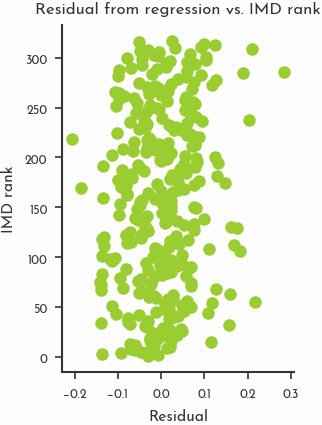

In [37]:
plt.scatter(df_dem_plus_IMD['residual'], df_dem_plus_IMD['IMD - Rank of average rank '], color='yellowgreen')
plt.xlabel('Residual')
plt.ylabel('IMD rank')
plt.title('Residual from regression vs. IMD rank')
plt.show()

### Ridge regression 

In [38]:
# Linear regression using sklearn and ridge regression

x = df_dem_plus[covar_opt].values.reshape(-1,len(covar_opt))
y = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

regr = linear_model.Ridge(alpha=1)

# fit regression comorbidities
regr.fit(x, y)
y_pred = regr.predict(x)

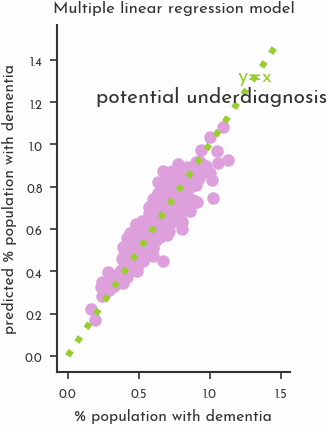

In [39]:
# comparison between true diagnosis value, and the value predicted by the multiple linear regression model 

plt.plot(np.arange(0, 1.5, 0.01), np.arange(0, 1.5, 0.01), ':', color='yellowgreen')
plt.scatter(y, y_pred, color='plum')
plt.xlabel('% population with dementia')
plt.ylabel('predicted % population with dementia')
plt.title('Multiple linear regression model')
plt.text(1.2, 1.3, r'y=x', fontsize=10, color='yellowgreen')
plt.text(0.2, 1.2, r'potential underdiagnosis', fontsize=10)
plt.show()

In [40]:
print(f'intercept:{regr.intercept_[0]}')
print('-------- \n coefficients of independent variables \n ')
for i, covar in enumerate(covar_opt):
    print(f'{covar}:{regr.coef_[0][i]} \n')

intercept:-1.0821847241346139
-------- 
 coefficients of independent variables 
 
over_65_pc:0.014226344996366031 

female_pc:0.020242517569894272 

ALevel_plus_pc:0.0005880121033282399 

white_pc:0.0002688326792120324 

HYP_afflicted_pc:0.020087549460594867 

DM_afflicted_pc:-0.011613828845730994 

STIA_afflicted_pc:0.10321012371005704 

GP_LAD_pc:0.04012779944921694 



In [41]:
#np.dot(np.array(x), regr.coef_[0]) + regr.intercept_[0]

### Lasso regression 

In [42]:
# Linear regression using sklearn and lasso 

x = df_dem_plus[covar_opt].values.reshape(-1,len(covar_opt))
y = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

regr = linear_model.Lasso(alpha=0.001)

# fit regression comorbidities
regr.fit(x, y)
y_pred = regr.predict(x)

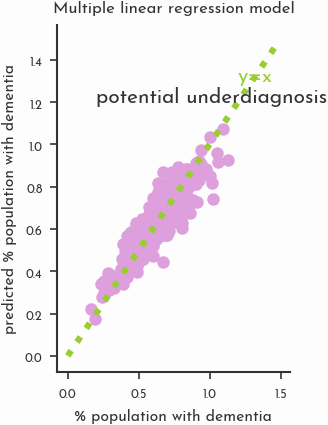

In [43]:
# comparison between true diagnosis value, and the value predicted by the multiple linear regression model 
true_val = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

plt.plot(np.arange(0, 1.5, 0.01), np.arange(0, 1.5, 0.01), ':', color='yellowgreen')
plt.scatter(y, y_pred, color='plum')
plt.xlabel('% population with dementia')
plt.ylabel('predicted % population with dementia')
plt.title('Multiple linear regression model')
plt.text(1.2, 1.3, r'y=x', fontsize=10, color='yellowgreen')
plt.text(0.2, 1.2, r'potential underdiagnosis', fontsize=10)
plt.show()

In [44]:
print(f'intercept:{regr.intercept_[0]}')
print('-------- \n coefficients of independent variables \n ')
for i, covar in enumerate(covar_opt):
    print(f'{covar}:{regr.coef_[i]} \n')

intercept:-1.1076648618619607
-------- 
 coefficients of independent variables 
 
over_65_pc:0.01594091279869921 

female_pc:0.019379468416876565 

ALevel_plus_pc:0.0012881916530099716 

white_pc:0.0006392067145049567 

HYP_afflicted_pc:0.01870254701543282 

DM_afflicted_pc:-0.0 

STIA_afflicted_pc:0.06691763631721452 

GP_LAD_pc:0.0 

